In [ ]:
#required packages
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from pymc3 import Model
import pymc3 as pm
import theano
import theano.tensor as tt
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.preprocessing import StandardScaler

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
# Load dataset
df = pd.read_csv('../data/denver_prop_with_ct_clean.csv')

In [ ]:
#convert to datetime format
df["list_date"] = pd.to_datetime(df["list_date"])
df["sale_date"] = pd.to_datetime(df["sale_date"])

In [ ]:
df

,rex_property_id,lotsizeacres,lotsizesqft,assdtotalvalue,markettotalvalue,marketvalueland,marketvalueimprovement,bedrooms,totalrooms,bathtotalcalc,...,OTHER,SINGLE,list_date,sale_date,sqft,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage
0,207973152,123,5358,29609,414100,133000,281100,4,0,3.5,...,False,True,2016-06-30,2016-08-12,1708.0,False,False,False,False,False
1,207973152,123,5358,29609,414100,133000,281100,4,0,3.5,...,False,True,2019-04-26,2019-05-29,1708.0,False,False,False,False,False
2,207973152,123,5358,29609,414100,133000,281100,4,0,3.5,...,False,True,2016-06-30,2016-08-12,1708.0,False,False,False,False,False
3,207973152,123,5358,29609,414100,133000,281100,4,0,3.5,...,False,True,2019-04-26,2019-05-29,1708.0,False,False,False,False,False
4,208397574,200,8712,33126,463300,110000,353300,5,16,3.5,...,False,True,2020-06-26,2020-08-10,2988.0,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277547,352759060,86,3746,27400,383228,78000,305228,2,5,2.0,...,False,False,2018-05-18,2018-06-28,1424.0,False,False,False,False,False
277548,121948410,201,8756,21190,296330,45000,251330,3,9,3.0,...,False,True,2020-09-08,2100-01-01,1570.0,False,False,False,False,True
277549,122775824,214,9322,42050,588049,180000,408049,4,0,3.5,...,False,True,2017-05-31,2100-01-01,3169.0,False,False,False,False,False
277550,93936156,5380,234353,50830,710864,233564,477300,4,17,4.5,...,False,True,2017-06-02,2100-01-01,2208.0,False,False,False,False,False


Current approach is trained on a particular discretized timeframe (say a quarter / 3 months). One potential exploration is to train the heirarchical models on separate discretized quarters and generate a time series on the changing sub-market classifications across the quarters. However, one concern is when a house is sold before a particular quarter and the model would assume that its corresponding sub-market has low supply?

In [ ]:
def gen_y(t_disc, data, t0=None):
    ''' 
    t_disc: datetime.timedelta(days = XX)
    t0: datetime.datetime(YYYY,MM,DD)
    '''

    if t0 is not None:
        listed = np.array(((data['list_date'] >= t0) & (data['list_date'] < t0 + t_disc)) | ((data['list_date'] < t0) & (data['sale_date'] >= t0)), dtype=np.int8)
        sale = np.array((data['sale_date'] >= t0) & (data['sale_date'] < t0 + t_disc), dtype = np.int8)
        return np.vstack((listed, sale)).T
    #else:
        #TODO


In [ ]:
y_2019Q2 = gen_y(datetime.timedelta(days = 90), df, datetime.datetime(2019,4,1))

In [ ]:
# Remove all rows that aren't listed in that period
listed_index = np.where(y_2019Q2[:,0] == 1)
df_2019Q2 = df.iloc[listed_index]

In [ ]:
df_2019Q2 = df_2019Q2.drop(columns=['rex_property_id'])

In [ ]:
# Build X matrix and Y target vector

X = df_2019Q2.drop(columns=['list_date','sale_date'])
X = X.reset_index(drop=True)

Y = y_2019Q2[np.where(y_2019Q2[:,0]==1)]

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42336 entries, 0 to 42335
Data columns (total 64 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   lotsizeacres                                         42336 non-null  int64  
 1   lotsizesqft                                          42336 non-null  int64  
 2   assdtotalvalue                                       42336 non-null  int64  
 3   markettotalvalue                                     42336 non-null  int64  
 4   marketvalueland                                      42336 non-null  int64  
 5   marketvalueimprovement                               42336 non-null  int64  
 6   bedrooms                                             42336 non-null  int64  
 7   totalrooms                                           42336 non-null  int64  
 8   bathtotalcalc                                        42336 non-nul

In [ ]:
X = X.to_numpy(dtype=np.float64)
X.shape

(42336, 64)

In [ ]:
K = 5 # Number of submarkets
n_homes, n_features = X.shape
mu_k_prior_var = 10
sigma_k_prior_var = 10
mu_b1_prior_var = 1
sigma_b1_prior_var = 1
mu_b2_prior_var = 1
sigma_b2_prior_var = 1

with Model() as baseline_mod:

    # Submarket latent variable
    p = pm.Dirichlet("p", a=np.ones(K)/K, shape=K)

    submarket = pm.Categorical('submarket', p=p, shape=n_homes)

    # Generate homes features 
    mu_k = pm.Normal('mu_k', mu=0, sigma=mu_k_prior_var, shape=(K,n_features))

    sigma_k = pm.Normal('sigma_k', mu=0, sigma=sigma_k_prior_var, shape=(n_features,n_features))

    homes = pm.MvNormal('homes', mu_k[submarket,:], sigma_k, observed=X)

    # Generate betas for "hedonic" regression
    mu_b1 = pm.Normal('mu_b1', mu=0, sigma=mu_b1_prior_var, shape=(K,n_features))

    sigma_b1 = pm.Normal('sigma_b1', mu=0, sigma=sigma_b1_prior_var, shape=(n_features,n_features))

    beta1 = pm.MvNormal('beta1', mu_b1[submarket,:], sigma_b1, shape=(n_homes,n_features))

    mu_b2 = pm.Normal('mu_b2', mu=0, sigma=mu_b2_prior_var, shape=(K,n_features))

    sigma_b2 = pm.Normal('sigma_b2', mu=0, sigma=sigma_b2_prior_var, shape=(n_features,n_features))

    beta2 = pm.MvNormal('beta2', mu_b2[submarket,:], sigma_b2, shape=(n_homes,n_features))

    # Final layer
    y1 = pm.Bernoulli('y1', p=1/(1+tt.exp(-tt.tensordot(homes,tt.transpose(beta1)))), observed = Y[:,0])
    y2 = pm.Bernoulli('y2', p=1/(1+tt.exp(-tt.tensordot(homes,tt.transpose(beta1)))), observed = Y[:,1])



    # y1 = pm.Normal('y1', mu=tt.dot(tt.matrix(homes),tt.transpose(tt.matrix(beta1)))[0,:], sigma=sigma_y1, shape=n_homes)
    # y1 = pm.Normal('y1', mu=1/(1+tt.exp(tt.tensordot(homes,tt.transpose(beta1)))), sigma=sigma_y1, observed = y_2019Q2[:,0])
    # y2 = pm.Normal('y2', mu=1/(1+tt.exp(tt.tensordot(homes,tt.transpose(beta2)))), sigma=sigma_y2, observed = y_2019Q2[:,1])
    
    # Deterministic cannot have observed argument
    # pred1 = pm.Deterministic('pred1', 1/(1+np.exp(-y1)), observed = y_2019Q2[:,0])
    # pred2 = pm.Deterministic('pred1', 1/(1+np.exp(-y2)), observed = y_2019Q2[:,1])

In [ ]:
# theano.config.exception_verbosity='high'

with baseline_mod:

    step1 = pm.Metropolis(vars=[p, mu_k, sigma_k, homes, mu_b1, sigma_b1, beta1, mu_b2, sigma_b2, beta2, y1, y2])
    step2 = pm.ElemwiseCategorical(vars=[submarket], values=np.arange(K))
    tr = pm.sample(1000, step = [step1, step2], start = {"sigma_k": np.eye(n_features), "sigma_b1": np.eye(n_features), "sigma_b2": np.eye(n_features)}, compute_convergence_checks=False)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  
/root/venv/lib/python3.7/site-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [beta2]
>>Metropolis: [sigma_b2]
>>Metropolis: [mu_b2]
>>Metropolis: [beta1]
>>Metropolis: [sigma_b1]
>>Metropolis: [mu_b1]
>>Metropolis: [sigma_k]
>>Metropolis: [mu_k]
>>Metropolis: [p]
>ElemwiseCategorical: [submarket]


/root/venv/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/root/venv/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
len(tr['submarket'])

4000

In [ ]:
values = []
counts = []

for i in range(20):
    value, count = np.unique(tr['submarket'][i+1500], return_counts = True)
    values.append(value)
    counts.append(count)

In [ ]:
values

[array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2])]

In [ ]:
counts

[array([7169,  281,  117]),
 array([7171,  281,  115]),
 array([7169,  281,  117]),
 array([7173,  281,  113]),
 array([7172,  281,  114]),
 array([7168,  281,  118]),
 array([7168,  281,  118]),
 array([7170,  281,  116]),
 array([7171,  281,  115]),
 array([7172,  281,  114]),
 array([7171,  281,  115]),
 array([7170,  281,  116]),
 array([7169,  281,  117]),
 array([7170,  281,  116]),
 array([7170,  281,  116]),
 array([7170,  281,  116]),
 array([7173,  281,  113]),
 array([7171,  281,  115]),
 array([7171,  281,  115]),
 array([7172,  281,  114])]

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrBr"))
  # This is added back by InteractiveShellApp.init_path()


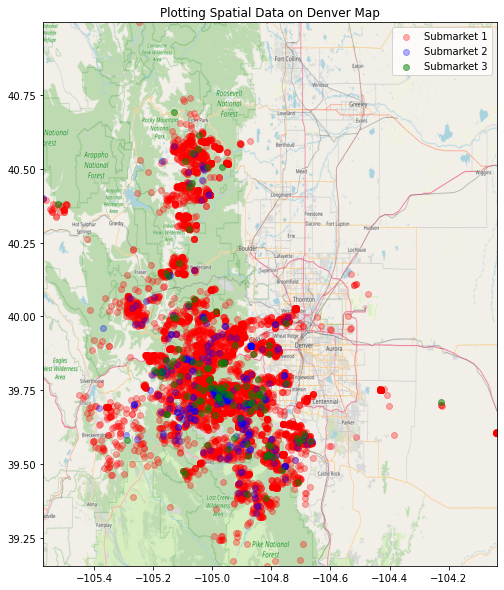

In [ ]:
denver = plt.imread('denver_map.png')
X_sub1 = df_2019Q2[tr['submarket'][1500] == 0]
X_sub2 = df_2019Q2[tr['submarket'][1500] == 1]
X_sub3 = df_2019Q2[tr['submarket'][1500] == 2]
BBox = (X_sub1.longitude.min(), X_sub1.longitude.max(),      
         X_sub1.latitude.min(), X_sub1.latitude.max())
        
fig, ax = plt.subplots(figsize = (10,10))

my_cmap = plt.cm.YlOrBr
my_cmap.set_under('w',1)

ax.scatter(X_sub1.longitude, X_sub1.latitude, color='r', alpha= 0.3, cmap=my_cmap, label="Submarket 1")
ax.scatter(X_sub2.longitude, X_sub2.latitude, color='b', alpha= 0.3, cmap=my_cmap, label="Submarket 2")
ax.scatter(X_sub3.longitude, X_sub3.latitude, color='g', alpha= 0.5, cmap=my_cmap, label="Submarket 3")
ax.set_title('Plotting Spatial Data on Denver Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.legend(loc='best')
ax.imshow(denver, zorder=0, extent = BBox, aspect= 'equal')

plt.show()

In [ ]:
def submarket_pymc3(trace_category):
    
    values = np.unique(trace_category)

    for i in range(len(values)):

        X_sub = X[trace_category == values[i]]
        Y_sub = Y[trace_category == values[i]]
        
        # Ensure that sub-market has both classifications
        labels = np.unique(Y_sub)
        if len(labels) == 1:
            continue
            
        X_train, X_test, y_train, y_test = train_test_split(X_sub, Y_sub, test_size=0.3)

        model_sub = LogisticRegression().fit(X_train, y_train[:,1])

        train_acc = model_sub.score(X_train, y_train[:,1])
        test_acc = model_sub.score(X_test, y_test[:,1])
        auc = roc_auc_score(y_test[:,1], model_sub.predict(X_test)) 
        
        exp_sales = sum(model_sub.predict_proba(X_test)[:,1])
        actual_sales = sum(y_test[:,1])

        print("Sub-Market #{} Demand Prediction".format(i+1))
        print("Number of Homes: {}".format(len(Y_sub)))
        print("Training Accuracy: {:.3f}%".format(train_acc*100))
        print("--- Testing ---")
        print("Testing Accuracy: {:.3f}%".format(test_acc*100))
        print("AUC: {:.3f}".format(auc))
        print("Expected #Sales: {}".format(round(exp_sales)))
        print("Actual #Sales: {}\n".format(actual_sales))

In [ ]:
submarket_pymc3(tr['submarket'][1500])

Sub-Market #1 Demand Prediction
Number of Homes: 7169
Training Accuracy: 72.140%
--- Testing ---
Testing Accuracy: 70.758%
AUC: 0.542
Expected #Sales: 629
Actual #Sales: 667

Sub-Market #2 Demand Prediction
Number of Homes: 281
Training Accuracy: 90.306%
--- Testing ---
Testing Accuracy: 87.059%
AUC: 0.500
Expected #Sales: 8
Actual #Sales: 11

Sub-Market #3 Demand Prediction
Number of Homes: 117
Training Accuracy: 69.136%
--- Testing ---
Testing Accuracy: 41.667%
AUC: 0.395
Expected #Sales: 15
Actual #Sales: 15



In [ ]:
np.unique(tr['submarket'][-1], return_counts = True)

(array([0, 4]), array([7552,   15]))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1c850c61-d934-4c85-b16d-3cb283df0c84' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>